In [1]:
cd /content/drive/My Drive/traffic

/content/drive/My Drive/traffic


In [2]:
# !unzip za_traffic_2020.zip

In [2]:
!pip install torch==1.4
!pip install torchvision==0.5.0

In [3]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-r_qf0j28
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-r_qf0j28
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266457 sha256=bb1a12cd2d6a77fd9bf32bbd8f91d1147ea239631ff64bddffd1c8166a9ae1e2
  Stored in directory: /tmp/pip-ephem-wheel-cache-fmax5fij/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import time
import shutil
import torch.nn as nn
from skimage import io
import torchvision
import cv2
import glob
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from albumentations.pytorch import ToTensor
from torchvision import utils
from albumentations import (HorizontalFlip, ShiftScaleRotate, VerticalFlip, Normalize,Flip,Compose, GaussNoise)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
# git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

error: Your local changes to the following files would be overwritten by checkout:
	.circleci/regenerate.py
	.circleci/unittest/linux/scripts/install.sh
	.circleci/unittest/linux/scripts/post_process.sh
	.circleci/unittest/linux/scripts/run_test.sh
	.circleci/unittest/linux/scripts/setup_env.sh
	packaging/build_cmake.sh
	packaging/build_conda.sh
	packaging/build_wheel.sh
	packaging/conda/build_vision.sh
	packaging/conda/switch_cuda_version.sh
	travis-scripts/run-clang-format/run-clang-format.py
Please commit your changes or stash them before you switch branches.
Aborting


In [7]:
# import json
# import cv2
# import pandas as pd
# def make_csv(path_data, path_data_json, save_path ):
#     json_train = json.load(open(path_data_json,'r'))

#     image_id = []
#     width    = []
#     height   = []
#     label    = []
#     classes  = []

#     x, y, w, h, area = [], [], [], [], []
#     mp = dict()

#     for img in json_train['annotations']:
#       image_id.append(img['image_id'])
#       x.append(img['bbox'][0])
#       y.append(img['bbox'][1])
#       w.append(img['bbox'][2])
#       h.append(img['bbox'][3])
#       area.append(img['area'])
#       label.append(img['category_id'])
#       # print(path_data+str(img['image_id'])+".png")
#       image = cv2.imread(path_data+str(img['image_id'])+".png")
#       width.append(image.shape[1])
#       height.append(image.shape[0])
#       # image = cv2.rectangle(image, (img['bbox'][0],img['bbox'][1]), (img['bbox'][0]+img['bbox'][2],img['bbox'][1]+img['bbox'][3]), (0,0,255), thickness=1)
#       # cv2_imshow(image)
#       classes.append(img['category_id'])
#       print(img['category_id'])
#       if img['category_id'] not in mp.keys():
#         mp[img['category_id']] =0
#       else:
#         mp[img['category_id']] +=1

#     print(mp)
#     import pandas as pd
#     data_train = pd.DataFrame({
#         'image_id':image_id,
#         'width':width,
#         'height': height,
#         'x':x,
#         'y':y,
#         'w':w,
#         'h':h,
#         'class': classes
#     }).to_csv(save_path)

In [6]:
path_train = "./za_traffic_2020/traffic_train/images/"
path_test  = "./za_traffic_2020/traffic_public_test/images/"

In [9]:
# cd ..

/content/drive/My Drive


In [7]:
#load_data
import random
import glob

all_train = glob.glob(path_train+"/*.png")
private_list =  glob.glob(path_test+"*.png")

for idx,img_id in enumerate(all_train):
  all_train[idx] = img_id.split('/')[-1].split('.')[0]

for idx,img_id in enumerate(private_list):
  private_list[idx] = img_id.split('/')[-1].split('.')[0]

random.shuffle(all_train)
ratio_train = 0.7
ratio_valid = 0.2

train_list   = all_train[:int(len(all_train)*ratio_train)]
valid_list   = all_train[int(len(all_train)*ratio_train):int(len(all_train)*(ratio_train+ratio_valid))]
test_list    = all_train[:-int((ratio_train+ratio_valid)*len(all_train))]

In [8]:
df_train = pd.read_csv('./za_traffic_2020/train.csv')

train_df = df_train[df_train['image_id'].isin(train_list)]
val_df = df_train[df_train['image_id'].isin(valid_list)]
test_df = df_train[df_train['image_id'].isin(test_list)]

print ("Train: ",train_df.shape)
print ("Validation: ",val_df.shape)
print ("Test: ",test_df.shape)

Train:  (7651, 9)
Validation:  (2224, 9)
Test:  (1102, 9)


In [92]:
from torchvision import transforms
def get_transforms(phase):
  list_transforms = []
  # if phase == 'train':
  #     list_transforms.extend([Flip(p=0.5)])
  
  list_transforms.extend([ToTensor(),])
  # list_transforms.extend(torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)))
  list_trfms = Compose(list_transforms,bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

  # return transforms.Compose([
  #       # transforms.Grayscale(num_output_channels=1),
  #       # transforms.Resize(input_size),
  #       # transforms.RandomGrayscale(0.1),
  #       transforms.ToTensor(),
  #       transforms.Normalize([0.485,], [0.229,])
  #   ])
  

  return list_trfms

In [98]:
from PIL import Image
import numpy as np
class Traffic_sign(Dataset):
    def __init__(self,data_frame,image_dir,phase='train'):
        
        # super().__init__()
        self.df = data_frame
        self.image_dir = image_dir
        self.images = data_frame['image_id'].unique()
        self.transforms = get_transforms(phase)
        
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,idx):
        image = str(self.images[idx]) + '.png'
#         image_arr = io.imread(os.path.join(self.image_dir,image))
        
        # image_arr = cv2.imread(os.path.join(self.image_dir,image), cv2.IMREAD_COLOR)
        # image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_arr = Image.open(os.path.join(self.image_dir,image)).convert("RGB")
        image_arr = np.asarray(image_arr)/255
        image_id = int(self.images[idx])
        point = self.df[self.df['image_id'] == image_id]

        boxes = point[['x', 'y', 'w', 'h']].values
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # area = torch.as_tensor(area, dtype=torch.float32)
        
        # there is only one class
        labels = torch.tensor((point[['class']].values.reshape(-1)).tolist(), dtype=torch.int64)
        # labels = torch.ones((point.shape[0],), dtype=torch.int64)
        # iscrowd =   torch.zeros(point[['class']].shape[0], dtype=torch.int64)
        # suppose all instances are not crowd
        iscrowd = torch.zeros((point.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        if self.transforms:
            sample = {
                'image': image_arr,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            sample = self.transforms(**sample)
            image = sample['image']
        
        target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
        
        return image, target

In [99]:
train_data = Traffic_sign(train_df,path_train,phase='train')
val_data = Traffic_sign(val_df,path_train,phase='validation')
test_data = Traffic_sign(test_df,path_train,phase='test')

In [100]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = DataLoader(
    train_data,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    val_data,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

test_data_loader = DataLoader(
    test_data,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [101]:
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    image = (image * 255).astype(np.uint8)
    return image

def plot_img(data,idx):
    out = data.__getitem__(idx)
    image = image_convert(out[0])
    image = np.ascontiguousarray(image)
    bb = out[1]['boxes'].numpy()
    for i in bb:
        cv2.rectangle(image, (i[0],i[1]), (i[2],i[3]), (0,255,0),2)
    plt.figure(figsize=(10,10))
    plt.imshow(image)

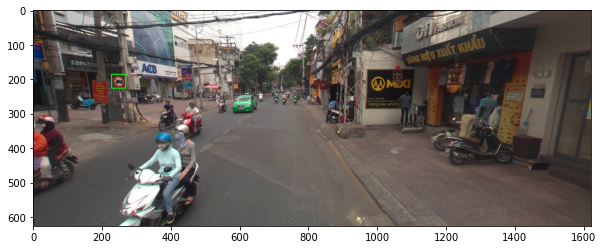

In [102]:
plot_img(train_data,10)

In [103]:
train_data.__getitem__(22)

(tensor([[[0.5961, 0.5961, 0.5961,  ..., 0.6510, 0.6510, 0.6510],
          [0.5961, 0.5961, 0.5961,  ..., 0.6510, 0.6510, 0.6510],
          [0.5961, 0.5961, 0.5961,  ..., 0.6510, 0.6510, 0.6510],
          ...,
          [0.6510, 0.6510, 0.6510,  ..., 0.6588, 0.6627, 0.6588],
          [0.6627, 0.6588, 0.6627,  ..., 0.6627, 0.6667, 0.6627],
          [0.6706, 0.6667, 0.6588,  ..., 0.6588, 0.6667, 0.6667]],
 
         [[0.6941, 0.6941, 0.6941,  ..., 0.7255, 0.7255, 0.7255],
          [0.6941, 0.6941, 0.6941,  ..., 0.7255, 0.7255, 0.7255],
          [0.6941, 0.6941, 0.6941,  ..., 0.7255, 0.7255, 0.7255],
          ...,
          [0.6510, 0.6510, 0.6510,  ..., 0.6353, 0.6353, 0.6314],
          [0.6627, 0.6588, 0.6588,  ..., 0.6431, 0.6392, 0.6392],
          [0.6706, 0.6627, 0.6549,  ..., 0.6392, 0.6471, 0.6431]],
 
         [[0.8431, 0.8431, 0.8431,  ..., 0.8941, 0.8941, 0.8941],
          [0.8431, 0.8431, 0.8431,  ..., 0.8941, 0.8941, 0.8941],
          [0.8431, 0.8431, 0.8431,  ...,

In [104]:
# !git clone https://github.com/pytorch/vision.git
%cd vision
!git checkout v0.3.0

!cp references/detection/utils.py ../
!cp references/detection/transforms.py ../
!cp references/detection/coco_eval.py ../
!cp references/detection/engine.py ../
!cp references/detection/coco_utils.py ../

/content/drive/My Drive/traffic/vision
error: Your local changes to the following files would be overwritten by checkout:
	.circleci/regenerate.py
	.circleci/unittest/linux/scripts/install.sh
	.circleci/unittest/linux/scripts/post_process.sh
	.circleci/unittest/linux/scripts/run_test.sh
	.circleci/unittest/linux/scripts/setup_env.sh
	packaging/build_cmake.sh
	packaging/build_conda.sh
	packaging/build_wheel.sh
	packaging/conda/build_vision.sh
	packaging/conda/switch_cuda_version.sh
	travis-scripts/run-clang-format/run-clang-format.py
Please commit your changes or stash them before you switch branches.
Aborting


In [105]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def build_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Stop here if you are fine-tunning Faster-RCNN

    # now get the number of input features for the mask classifier
    # in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    # hidden_layer = 256
    # # and replace the mask predictor with a new one
    # model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
    #                                                    hidden_layer,
    #                                                    num_classes)

    return model

In [106]:

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 8

# get the model using our helper function
model = build_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [107]:
# !git clone https://github.com/pytorch/vision.git
# %cd vision
# !git checkout v0.3.0
# !cp references/detection/utils.py ../
# !cp references/detection/transforms.py ../
# !cp references/detection/coco_eval.py ../
# !cp references/detection/engine.py ../
# !cp references/detection/coco_utils.py ../

In [109]:
cd ..

/content/drive/My Drive/traffic


In [110]:
from engine import train_one_epoch, evaluate
num_epochs = 10


for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, valid_data_loader, device=device)

AssertionError: ignored

In [ ]:
# import math
# import sys
# import time
# import torch

# import torchvision.models.detection.mask_rcnn

# from coco_utils import get_coco_api_from_dataset
# from coco_eval import CocoEvaluator
# import utils

# train_loss=[]
# total_train_loss = []
# def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
#     model.train()
#     metric_logger = utils.MetricLogger(delimiter="  ")
#     metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
#     header = 'Epoch: [{}]'.format(epoch)

#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1. / 1000
#         warmup_iters = min(1000, len(data_loader) - 1)

#         lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

#     for images, targets in metric_logger.log_every(data_loader, print_freq, header):
#         images = list(image.to(device) for image in images)
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#         loss_dict = model(images, targets)

#         losses = sum(loss for loss in loss_dict.values())
#         train_loss.append(losses.item())
#         # reduce losses over all GPUs for logging purposes
#         loss_dict_reduced = utils.reduce_dict(loss_dict)
#         losses_reduced = sum(loss for loss in loss_dict_reduced.values())

#         loss_value = losses_reduced.item()

#         if not math.isfinite(loss_value):
#             print("Loss is {}, stopping training".format(loss_value))
#             print(loss_dict_reduced)
#             sys.exit(1)

#         optimizer.zero_grad()
#         losses.backward()
#         optimizer.step()

#         if lr_scheduler is not None:
#             lr_scheduler.step()

#         metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
#         metric_logger.update(lr=optimizer.param_groups[0]["lr"])
#     epoch_train_loss = np.mean(train_loss)
#     total_train_loss.append(epoch_train_loss)
#     return metric_logger

In [52]:
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, pretrained_backbone=True)

In [53]:
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# num_classes =  2 # 1 class (wheat) + background

# # get number of input features for the classifier
# in_features = model.roi_heads.box_predictor.cls_score.in_features

# # replace the pre-trained head with a new one
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# model.to(device)
# params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.Adam(params, lr=0.0001, weight_decay=0.0005)

# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
#                                                step_size=3,
#                                                gamma=0.1)

# # num_classes = 8  # 1 class (wheat) + background

# # # get number of input features for the classifier
# # in_features = model.roi_heads.box_predictor.cls_score.in_features

# # # replace the pre-trained head with a new one
# # model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# # model.to(device)
# # params = [p for p in model.parameters() if p.requires_grad]
# # optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# # lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
# #                                                step_size=3,
# #                                                gamma=0.1)

In [54]:
# from engine import evaluate
# num_epochs = 500

# for epoch in range(num_epochs):
#     # train for one epoch, printing every 10 iterations
#     train_one_epoch(model, optimizer,train_data_loader, device, epoch, print_freq=10)
#     # update the learning rate
#     lr_scheduler.step()
#     # evaluate on the valid dataset
#     evaluate(model, valid_data_loader, device=device)

In [55]:
torch.ones((2,), dtype=torch.int64)

tensor([1, 1])

In [111]:
df = pd.read_csv('/content/drive/My Drive/traffic/za_traffic_2020/train.csv')

In [ ]:
df